In [1]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD.readers import *
from MDPD import utils, MDPD
import matplotlib.pyplot as plt
import matplotlib

----
## Read Data

In [2]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/'
# folder = '/Users/vincent/Documents/Research/MDPD/crowdsourcing_datasets'

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'bird', 'bluebird_crowd.txt'), os.path.join(folder, 'bird', 'bluebird_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:], dtype=np.bool)
print train.shape

In [3]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'dog', 'dog_crowd.txt'), os.path.join(folder, 'dog', 'dog_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

2018-04-09 12:43:12,809 : INFO : Data has missing values. A new label is created to represent the missing values.


(807, 109, 5)


In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'rte', 'rte_crowd.txt'), os.path.join(folder, 'rte', 'rte_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'trec', 'trec_crowd.txt'), os.path.join(folder, 'trec', 'trec_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'web', 'web_crowd.txt'), os.path.join(folder, 'web', 'web_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

#### Update global variables

In [4]:
NSAMPLE, DIM, NVOCAB = train.shape
EFF_NVOCAB = NVOCAB-1 if reader.is_missing_value else NVOCAB

---
## Analysis

## Original Mutual Information Residue

In [5]:
%%time
# Original mutual information residue (G score)
score_origin = utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
sigma_origin = score_origin.sum(axis=1)
print np.sum(score_origin) / (DIM * (DIM-1))

0.2921120360257613
CPU times: user 50 ms, sys: 43.8 ms, total: 93.9 ms
Wall time: 35.6 ms


MDPD/utils.py:213: RuntimeWarning: divide by zero encountered in log
  log_second_scaled = np.log(second_masked)


#### Reference G Statistics

In [6]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100., (EFF_NVOCAB**2 - 1)) / (2 * NSAMPLE) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.018945423895224595, 0.01548685882263236, 0.013821022045587794, 0.011304266172500084, 0.008884051741608823]


## Mutual Information Residue if use the true label as the posterior distribution

In [7]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(label,label.max()+1)
utils.log_replace_neginf(log_post)

/home/vzhao/.virtualenvs/tf/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [8]:
%%time
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

Mutual Information Residue if use the true label as the posterior distribution
0.027165747111536548
CPU times: user 294 ms, sys: 263 ms, total: 557 ms
Wall time: 185 ms


#### [Plot] Mutual Information Residue if use the true label as the posterior distribution vs. Raw Residue

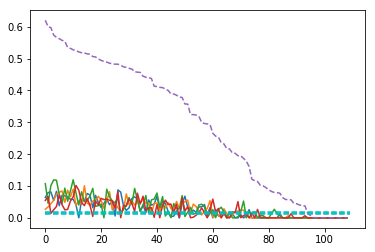

In [9]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

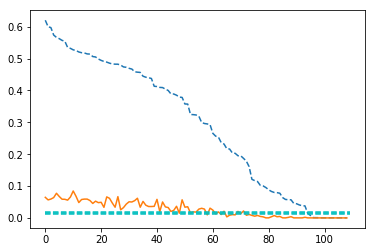

In [10]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Mixture Model with Feature Selection

#### Feature Ranking

In [ ]:
%%time
features, sigma = utils.Feature_Selection.MI_feature_ranking(train, lock=lock)
print features

#### Accuracy and Mutual Information Residue

In [11]:
Ntop = 15

In [12]:
# Feature Selection
model = MDPD.MDPD_standard()
model.fit(train, ncomp=5, init='majority', verbose=True, features=Ntop, epoch=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train)

2018-04-09 12:43:48,117 : INFO : Training an MDPD with dimension 109, 15 features, sample size 807, vocab size 5 and the target number of components 5
MDPD/utils.py:94: RuntimeWarning: divide by zero encountered in log
  log_votes = np.log(votes)
MDPD/MDPD.py:241: RuntimeWarning: divide by zero encountered in log
  log_margin_prob = np.log(data.sum(axis=0) / data.shape[0])
MDPD/utils.py:221: RuntimeWarning: divide by zero encountered in log
  log_second = np.log(second)
MDPD/utils.py:222: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (log_second - log_first)
2018-04-09 12:43:48,291 : INFO : iteration 0; log-likelihood (feature selection) -12.035329; log_likelihood -32.562607;information residue 0.004256
2018-04-09 12:43:48,448 : INFO : iteration 1; log-likelihood (feature selection) -12.006543; log_likelihood -32.487970;information residue 0.004291
2018-04-09 12:43:48,610 : INFO : iteration 2; log-likelihood (feature selection) -11.999150; log_likelihood -32.47

In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [ ]:
log_post = model.log_posterior(train)
score, weights = utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
sigma_condition = score.sum(axis=1)
print 'Mutual Information Residue of the model with feature selection'
print np.sum(sigma_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM-1))
plt.plot(sigma_origin[idx] / (DIM-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM-1), '--')
plt.plot(np.sum(score_condition[idx, :] * weights[np.newaxis, :], axis=1) / (DIM-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Vanilla Model Performance
#### Accuracy and Mutual Information Residue

In [ ]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD_standard()
model_basic.fit(train, ncomp=EFF_NVOCAB, init='majority', verbose=False, epoch=50, lock=lock)
model_basic.accuracy(train, label)
model_basic.MI_residue(train)

In [ ]:
log_post = model_basic.log_posterior(train)
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

print 'Mutual Information Residue (within the selected features)'
score_select = score[features[:Ntop, np.newaxis], features[:Ntop], :]
res_select = np.sum(score_select.sum(axis=1) * weights[np.newaxis, :]) / (Ntop * (Ntop - 1))
print res_select

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()